<a href="https://colab.research.google.com/github/BertrandCoquard/Kaggle/blob/main/_Example_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection

In [ ]:
#Run once per session
!pip install fastai wwf -q --upgrade


In [ ]:
#hide_input
from matplotlib import patches, patheffects

from wwf.utils import state_versions
state_versions(['fastai', 'fastcore', 'wwf'])

from fastai.vision.all import *

import os
import numpy as np
import torch

# from fastai import untar_data

import warnings
warnings.filterwarnings('ignore')

## Object Detection

Finding the localized area in which an object presides from two points, the bottom left and top right

![](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/06/maxresdefault.jpg)

# Data Set import : 

In [ ]:
path = untar_data(URLs.PASCAL_2007)
list(path.iterdir())

[Path('/root/.fastai/data/pascal_2007/train.json'),
 Path('/root/.fastai/data/pascal_2007/valid.json'),
 Path('/root/.fastai/data/pascal_2007/train.csv'),
 Path('/root/.fastai/data/pascal_2007/test.csv'),
 Path('/root/.fastai/data/pascal_2007/test'),
 Path('/root/.fastai/data/pascal_2007/segmentation'),
 Path('/root/.fastai/data/pascal_2007/tmp'),
 Path('/root/.fastai/data/pascal_2007/test.json'),
 Path('/root/.fastai/data/pascal_2007/train')]

In [ ]:
len((path/'train').ls())

5012

In [ ]:
len((path/'test').ls())

4952

We'll want to read out of the `train.json`

In [ ]:
trn_j = json.load((path/'train.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

The loaded json data file has the key images.
The key's value is in turn a list of key:value pairs, each of which contain :




1.   filename of the image
2.   height of the image
3.   id of the image using which other keys form a link to the image
4.   width of the image







In [ ]:
# We are saving the key values as constants so that it keeps the code clean and easy to work with
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']

trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
 {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
 {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26},
 {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]

Similarly, it has another key **annotations** which provide info like:


1.   bbox - gives the bounding box references
2.   category_id - a number that is mapped to the class the object belongs to
3.  image_id - this forms a link with the images key


**Note on Bounding Box:**

In the above output we see bbox and it has 4 values associated with it.
Bounding box is the box that is fit around the object that is detected and labeled.
It is not always perfect and might miss on capturing the full object.
Among the four values, first two are y and x values, which give the top left corner of the bounding box.
Unlike in Mathematics where we represent images as rows X columns, in computer vision the resolution is represented by columns X rows.
The next two numbers represent height and width of the image.



In [ ]:
trn_j[ANNOTATIONS][:2]

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0}]

Below we see another key categories and what it contains.
To know the actual category of the object in the image, there is a mapping between categories and annotations.

In [ ]:
trn_j[CATEGORIES][:4]

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'}]

Now, we will put our data (cats, file names, and file id, bourding box) into dictionaries 

In [ ]:
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])

trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])

trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [ ]:
im0_d = trn_j[IMAGES][0]

im0_d[FILE_NAME] , im0_d[ID]

('000012.jpg', 12)

Next, the question is **how do we get our labels?** `fastai` has a `get_annotations` function that we can use to grab the image and their bounding box. The one-line documentation states:
"Open a COCO style json in `fname` and returns the list of filenames (with mabye `prefix`) and labelled bounding boxes."

In [ ]:
imgs, lbl_bbox = get_annotations(path/'train.json')

In [ ]:
imgs[0]

'000012.jpg'

In [ ]:
lbl_bbox[0]

([[155, 96, 351, 270]], ['car'])

A defaultdict is useful any time you want to have a default dictionary entry for new keys. Here we create a dict from image IDs to a list of annotations (tuple of bounding box and class id).

We convert VOC's height/width into top-left/bottom-right, and switch x/y coords to be consistent with numpy.

defaultdict() - in a normal dict, if a key doesn't already exist, it must be set to some value.
Using defaultdict, if the key doesnt exist, it will assign it a default value.
Here we are interchanging first two values of bbox so that it stays consistent with numpy representation of images.
The 3rd and 4th values are also modified so that they represent the x and y values of bottom right corner of the box.



In [ ]:
trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
        
len(trn_anno)

2501

In [ ]:
im_a = trn_anno[im0_d[ID]]
im0_d, im_a 


({'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 [(array([ 96, 155, 269, 350]), 7)])

In [ ]:
im0_a = im_a[0]
im0_a

(array([ 96, 155, 269, 350]), 7)

In [ ]:
cats[7]

'car'

## Visualize our dataset : 

### Only one object : 

In [ ]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [ ]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='red'), patheffects.Normal()])

In [ ]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [ ]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [ ]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

In [ ]:
im =Image.open((path/'train'/im0_d[FILE_NAME]))

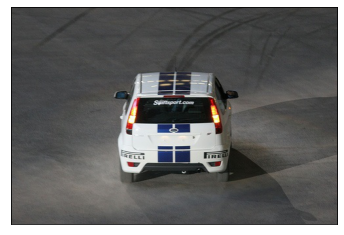

In [ ]:
ax = show_img(im)

### Draw associated box with label :

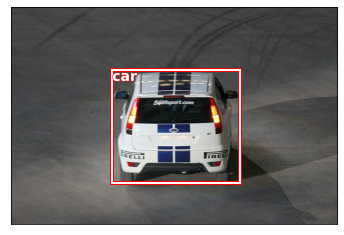

In [ ]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])

# Multiple objects detection : 

In [ ]:
# trn_fns

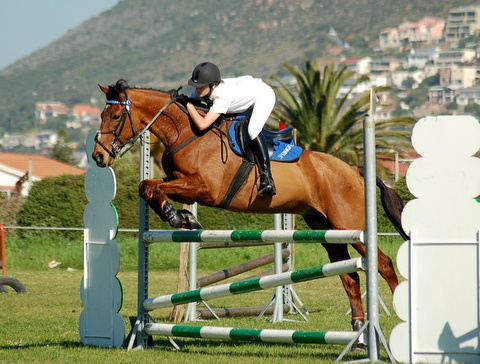

In [ ]:
Image.open((path/'train'/trn_fns[17]))

### Draw associated boxes with label :

In [ ]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann: 
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)


In [ ]:
def draw_idx(i):
    im_a = trn_anno[i] # returns binding box values and the object class for image with id i
    im =Image.open((path/'train'/trn_fns[i]))
    print(im.shape)
    draw_im(im, im_a)

(364, 480)


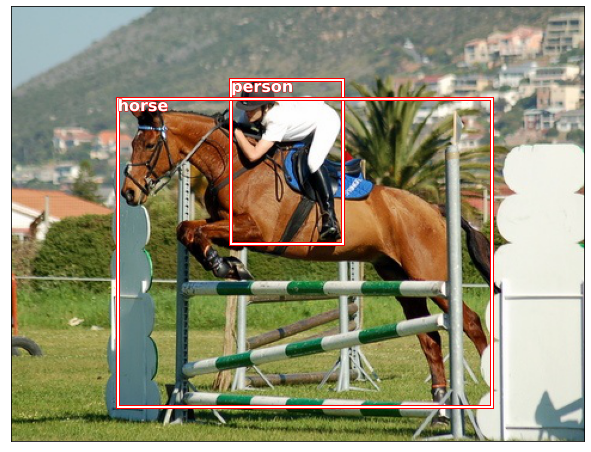

In [ ]:
draw_idx(17)

Next, we want to be able to quickly look up a corresponding image to it's label. We'll use a dictionary

In [ ]:
img2bbox = dict(zip(imgs, lbl_bbox))

Let's check the first item

In [ ]:
first = {k: img2bbox[k] for k in list(img2bbox)[:1]}; first

{'000012.jpg': ([[155, 96, 351, 270]], ['car'])}

Great! Now let's build our `DataBlock`. We'll have two outputs, the bounding box itself and a label, with one input.

In [ ]:
getters = [lambda o: path/'train'/o, lambda o: img2bbox[o][0], lambda o: img2bbox[o][1]]

For our transforms, we'll use some of the ones we defined earlier

In [ ]:
item_tfms = [Resize(128, method='pad'),]
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

Why do we need a custom `get_images`? Because we want our **images** that came back to us, not the entire folder

In [ ]:
def get_train_imgs(noop):  return imgs

We'll now make our `DataBlock`. We want to adjust `n_inp` as we expect two outputs

In [ ]:
pascal = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 splitter=RandomSplitter(),
                 get_items=get_train_imgs,
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

In [ ]:
dls = pascal.dataloaders(path/'train')

In [ ]:
dls.c = 20

In [ ]:
dls.vocab, dls.c, len(dls.train_ds), len(dls.valid_ds)

(['#na#', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'],
 20,
 2001,
 500)

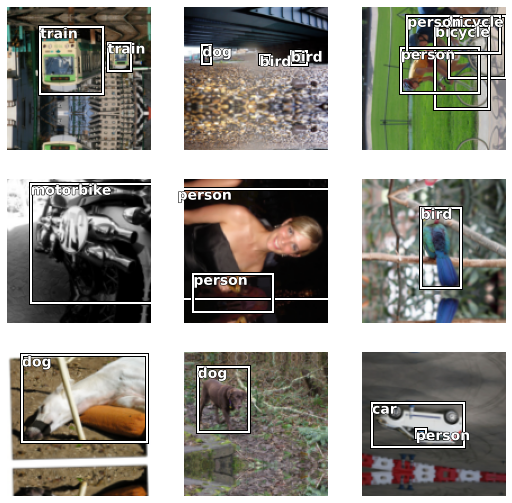

In [ ]:
dls.show_batch()

# The Model

The architecture we are going to use is called `RetinaNet`. If you want to explore what's going on in the code I'd recommend the Object Detection lesson [here](https://www.youtube.com/watch?v=Z0ssNAbe81M&t=4496s)

Let's import it:

In [ ]:
from wwf.vision.object_detection import *
from wwf.vision.object_detection.helper.object_detection_helper import *
from wwf.vision.object_detection.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from wwf.vision.object_detection.models.RetinaNet import RetinaNet
from wwf.vision.object_detection.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

We're still going to use transfer learning here by creating an `encoder` (body) of our model and a head

In [ ]:
encoder = create_body(resnet34(), pretrained=True)

Now that we have our encoder, we can call the `RetinaNet` architecture. We'll pass in the encoder, the number of classes, and what we want our final bias to be on the last convolutional layer (how we initialize our model). Jeremy has his example at -4 so let's use this

In [ ]:
get_c(dls)

20

In [ ]:
arch = RetinaNet(encoder, get_c(dls), final_bias=-4)

Another big difference is the head of our model. Instead of our linear layers with pooling layers:

In [ ]:
create_head(124, 4)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(248, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=248, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=4, bias=False)
)

We have one with a smoother, a classifer, and a `box_regressor` (to get our points)

In [ ]:
arch.smoothers

ModuleList(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
arch.classifier

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
arch.box_regressor

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

## Loss Function
Now we can move onto our loss function. For RetinaNet to work, we need to define what the aspect ratio's and scales of our image should be. The paper used [1,2**(1/3), 2**(2/3)], but they also used an image size of 600 pixels, so even the largest feature map (box) gave anchors that covered less than the image. But for us it would go over. As such we will use -1/3 and -2/3 instead. We will need these for inference later!

In [ ]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]

Let's make our loss function, which is `RetinaNetFocalLoss`

In [ ]:
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)

Now let's make our `Learner`!

We want to freeze our `encoder` and keep everything else unfrozen to start

In [ ]:
def _retinanet_split(m): return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

In [ ]:
learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split)

In [ ]:
learn.freeze()

Now let's train!

In [ ]:
lr = 1e-2
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learn.fit_one_cycle(10,lr)

epoch,train_loss,valid_loss,time
0,4.760530,3.284762,09:11
1,3.926275,3.309992,08:50
2,3.773786,3.247858,08:50
3,3.518520,3.204137,08:49
4,3.392812,3.179523,08:50
5,3.314871,3.166714,08:49
6,3.266470,3.161173,08:50
7,3.235166,3.157174,08:49
8,3.213315,3.155160,08:50
9,3.199502,3.154886,08:50


## Word of Warning:

`show_results` and `predict` both do not currently work. I'd recommend utilizing the [IceVision](https://github.com/airctic/icevision) library for your Object Detection needs.